In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

# Electronic Energy Minimisation

A central problem of electronic structure simulations is finding the ground state
configuration of many interacting electrons.  Within MESS this is handled by:

* building a `Hamiltonian` by selecting how to model the quantum-mechanical interactions
  with the `xc_method` argument.
* minimisation of the total energy subject to the constraint of orthonormal orbitals.

On the second point, there are many possible approaches to solving this constrained
optimisation problem.  In the following we setup minimising the total energy with the
[Adam optimiser](https://optax.readthedocs.io/en/latest/api/optimizers.html#adam)
from the [optax library](https://optax.readthedocs.io/en/latest/index.html).


:::{note}
The following code cell will install MESS into the Google Colab runtime.
Select the 🚀 in the toolbar above to try this out!
:::

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install git+https://github.com/graphcore-research/mess.git

  Cloning https://github.com/graphcore-research/mess.git to /tmp/pip-req-build-d9if0aqh
  Running command git clone --filter=blob:none --quiet https://github.com/graphcore-research/mess.git /tmp/pip-req-build-d9if0aqh
  Resolved https://github.com/graphcore-research/mess.git to commit e849e178ac3b169ceb4550e0bf7141e019d5105e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rpmuller/pyquante2 (to revision pure) to /tmp/pip-install-jn1k7mb6/pyquante2_4c59b410fc6b4bcd8e77d894edf16dc0
  Running command git clone --filter=blob:none --quiet https://github.com/rpmuller/pyquante2 /tmp/pip-install-jn1k7mb6/pyquante2_4c59b410fc6b4bcd8e77d894edf16dc0
  Running command git checkout -b pure --track origin/pure
  Switched to a new branch 'pure'
  Branch 'pure' set up to track remote branch 'pure' from 'origin'.
  Resolved https://github.com/rpm

In [3]:
import jax
import jax.numpy as jnp
import optax
import seaborn as sns
from tqdm.notebook import tqdm

from mess import Hamiltonian, basisset
from mess.structure import nuclear_energy
from mess.interop import from_pyquante

sns.set_theme(style="whitegrid")

To start with we show how to build a molecule by using the samples that are packaged as part of the
[pyquante](https://github.com/rpmuller/pyquante2) project.  We use use methane which you can rotate below:

In [4]:
mol = from_pyquante("ch4")
mol

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Structure(atomic_number=i64[5](numpy), position=f64[5,3](numpy))

Next we build up the components of our simulation:
* basis set: describes the linear combination of Gaussian orbitals used to represent the molecular orbitals and from this
  representation we can derive the electron density.
* Hamiltonian: describing the total energy of the many electrons interacting in the field generated by the nuclear cores.
  We use the widely used PBE exchange-correlation approximation of density functional theory.
* gradient descent optimiser: we use the [Adam optimiser](https://optax.readthedocs.io/en/latest/api/optimizers.html#adam)
  from the [optax library](https://optax.readthedocs.io/en/latest/index.html).

In [5]:
basis = basisset(mol, "6-31g")
H = Hamiltonian(basis, xc_method="pbe")
optimiser = optax.adam(learning_rate=0.1)

Next we define a function that evaluates the total energy given an arbitrary matrix $Z$
which applies the orthonormal constraint.  This efffectively converts the minimisation
problem into an unconstrained optimisation one.

In [6]:
E_n = nuclear_energy(mol)


@jax.jit
@jax.value_and_grad
def total_energy(Z):
    C = H.orthonormalise(Z)
    P = basis.density_matrix(C)
    return H(P) + E_n

We use a somewhat arbitrary initial guess and use the Adam optimiser to minimise
the total energy.  The function transformation
[jax.value_and_grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html)
uses automatic differentiation to evaluate both the energy and the gradient of the
energy with respect to the trial matrix $Z$.

In [7]:
Z = jnp.eye(basis.num_orbitals)
state = optimiser.init(Z)
history = []

for _ in (bar := tqdm(range(200))):
    e, grads = total_energy(Z)
    updates, state = optimiser.update(grads, state)
    Z = optax.apply_updates(Z, updates)
    history.append(e)
    bar.set_description(f"Total energy: {e:0.06f} (Hartree)")

  0%|          | 0/200 [00:00<?, ?it/s]

Next we can look at how the variation in the total energy through the optimisation process.

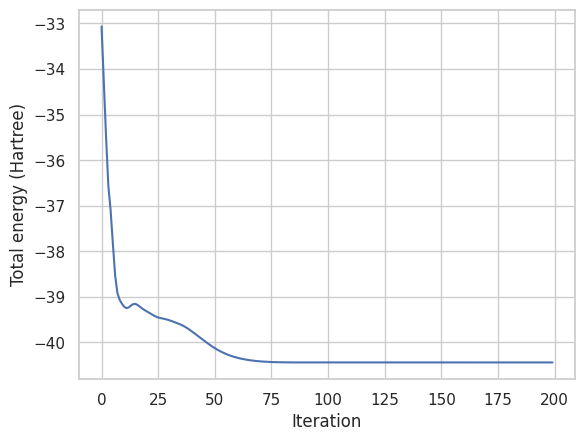

In [8]:
history = jnp.stack(history)
ax = sns.lineplot(history)
ax.set_xlabel("Iteration")
ax.set_ylabel("Total energy (Hartree)");